# LSTM Implementaton - Nasdaq-100 data

**Notebook Summary**


**Granularity**: minute data

**Source**: Refinitiv

**Time period**: 05-10-2023 / 05-19-2023

**Model**: LSTM

#Importing libraries

In [ ]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore")
import io
import math
import pandas as pd
import numpy as np
import datetime

# Keras
import keras
from keras.layers import *
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

# Sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded = files.upload()

# Load data


In [ ]:
# Import raw data
data = pd.read_csv(io.BytesIO(uploaded['Nasdaq-100-new.csv']), sep = ';', parse_dates = False) 

# Exploratory analysis

In [ ]:
data.head()

,Local Date,Local Time,Close,Net,%Chg,Open,Low,High
0,18-May-2023,21:00,"16.493,18","1,4","0,01%","16.491,86","16.491,67","16.501,19"
1,18-May-2023,20:59,"16.491,78","-0,22","0,00%","16.491,53","16.488,36","16.492,14"
2,18-May-2023,20:58,"16.492,00","2,67","0,02%","16.486,84","16.486,64","16.493,85"
3,18-May-2023,20:57,"16.489,33","1,76","0,01%","16.487,52","16.485,84","16.489,48"
4,18-May-2023,20:56,"16.487,57","0,61","0,00%","16.483,53","16.479,80","16.491,54"


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Local Date  2730 non-null   object
 1   Local Time  2730 non-null   object
 2   Close       2730 non-null   object
 3   Net         2730 non-null   object
 4   %Chg        2730 non-null   object
 5   Open        2730 non-null   object
 6   Low         2730 non-null   object
 7   High        2730 non-null   object
dtypes: object(8)
memory usage: 170.8+ KB


In [ ]:
# Set a time index
data['TimeDate'] = pd.to_datetime(data['Local Date'] + ' ' + data['Local Time'])
data.set_index('TimeDate', inplace = True)
data = data[['Close']]
data.sort_index(inplace = True)

In [ ]:
# Make some adjustment to read data properly
data['Close'] = [s.replace('.', '').replace(',', '.') for s in data['Close']]
data['Close'] = data['Close'].astype(np.float64)

In [ ]:
data.head()

,Close
TimeDate,
2023-05-10 14:31:00,15858.60
2023-05-10 14:32:00,15889.42
2023-05-10 14:33:00,15896.19
2023-05-10 14:34:00,15897.66
2023-05-10 14:35:00,15896.74


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2730 entries, 2023-05-10 14:31:00 to 2023-05-18 21:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2730 non-null   float64
dtypes: float64(1)
memory usage: 42.7 KB


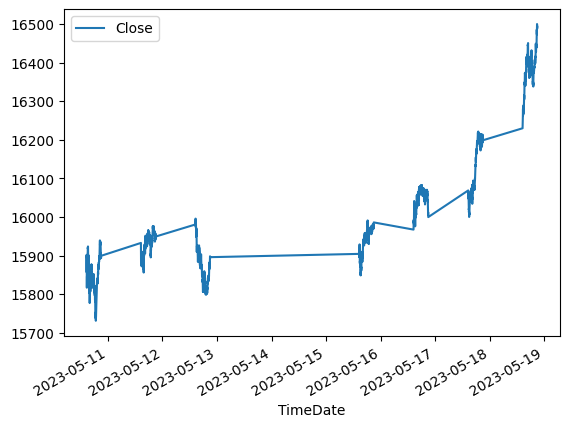

In [ ]:
# Plot the closing price
data.plot()
plt.show()

In [ ]:
# Create a new feature
log_returns = np.log(data["Close"]).diff(1) 
data["log_returns"] = log_returns 

In [ ]:
# Refine the dataset
data = data[["log_returns"]]

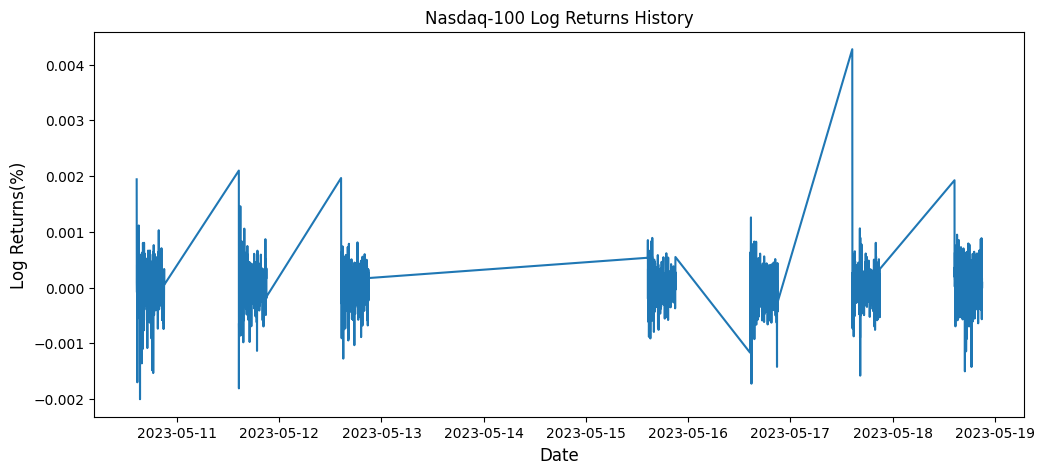

In [ ]:
# Plot the log returns
plt.figure(figsize=(12,5))
plt.title('Nasdaq-100 Log Returns History')
plt.plot(data)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Log Returns(%)', fontsize = 12)
plt.show()

In [ ]:
# Drop the first row containing a NaN value
data = data[1:]
data

,log_returns
TimeDate,
2023-05-10 14:32:00,0.001942
2023-05-10 14:33:00,0.000426
2023-05-10 14:34:00,0.000092
2023-05-10 14:35:00,-0.000058
2023-05-10 14:36:00,-0.000087
...,...
2023-05-18 20:56:00,0.000036
2023-05-18 20:57:00,0.000107
2023-05-18 20:58:00,0.000162


#Data processing

Before building up the model, the dataset is initially divided into two subsets: a training set and a test set, relatively with 80% and 20% of data. In order to capture relevant patterns and trends, a 60-day window is applied as a look-back period. This means that the model examines the historical data from the preceding 60 days to make predictions for the future. Specifically, our objective is to forecast the price for the upcoming 7 days, which serves as the look-forward variable. By employing this methodology, we aim to achieve accurate predictions by leveraging the historical information available within the specified time frame.

### Train-Test split

In [ ]:
# Train and test split
ratio = 0.8
train_size = int(len(data)* ratio) 
train_data = data[:train_size]
test_data = data[train_size:]

In [ ]:
train_data

,log_returns
TimeDate,
2023-05-10 14:32:00,0.001942
2023-05-10 14:33:00,0.000426
2023-05-10 14:34:00,0.000092
2023-05-10 14:35:00,-0.000058
2023-05-10 14:36:00,-0.000087
...,...
2023-05-17 18:20:00,-0.000051
2023-05-17 18:21:00,0.000099
2023-05-17 18:22:00,0.000483


### Building input features

In [1]:
# Define the look-back and look-forward variables
look_back = 50
look_forward = 10

In [ ]:
# Convert an array of values into a dataset matrix

def create_features(data, look_back=50, look_forward=10):
    dataX, dataY = [], []
    np.array(dataY)
    for k in range(len(data)-look_back-1):
        a = data[k:(k + look_back), 0]
        if len(data[k + look_back: k + look_back + look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(data[k + look_back: k + look_back + look_forward, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Generate train X and train Y data
trainX, trainY = create_features(train_data.values, look_back, look_forward)

In [ ]:
# Generate test X and test Y data
testX, testY = create_features(test_data.values, look_back, look_forward)

###Reshape to 3D data

In [ ]:
# Reshape input to be (samples, time steps, features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# Print out the shape of train and test X/Y
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2124, 50, 1)
(2124, 10)
(487, 50, 1)
(487, 10)


#LSTM Model Builder

In [ ]:
# Create a function that build an LSTM 

def create_lstm(input_shape = (look_back, 1), lstm_units=128, dense_units=10, drop_rate = 0.1):
    # Initialising the LSTM
    model = Sequential()

    # Adding the LSTM layer and some dropout regularization
    model.add(LSTM(units=lstm_units, input_shape=input_shape, stateful=False))
    model.add(Dropout(rate = drop_rate))

    # Adding a Dense layer
    model.add(Dense(units= lstm_units))
    model.add(Dropout(rate = drop_rate))
    model.add(Dense(units= lstm_units))
    model.add(Dropout(rate = drop_rate))
    model.add(Dense(units= dense_units))

    # Compiling the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
    return model


In [ ]:
# Instantiate an LSTM model to wrap in KerasRegressor
lstm = KerasRegressor(build_fn = create_lstm, verbose=0)

# Block Time Series Split and GridSearch CV

In [ ]:
# Define a Block Time Series Split (no overlapping data)
class BlockTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            end = start + k_fold_size
            mid = int(0.5 * (end - start)) + start
            yield indices[start: mid], indices[mid + margin: end]

In [ ]:
# Define the number of splits and get some metrics
btscv = BlockTimeSeriesSplit(n_splits= 5)

###Define the parameters to tune

In [ ]:
# Define the parameter grid for GridSearch
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 15, 20],
    'drop_rate' : [0.1, 0.15],
    'lstm_units':[64, 128, 256]}

###Run GridSearchCV

In [ ]:
# Create the GridSearchCV object with BlockTimeSeriesSplit
#grid_search = GridSearchCV(estimator = lstm, param_grid = param_grid, cv = btscv, scoring = 'neg_mean_squared_error')

In [ ]:
# Fit the data to the GridSearchCV object
#grid_result = grid_search.fit(trainX, trainY)

In [ ]:
# Print the best parameters and best score
#best_params = grid_result.best_params_
#best_score = grid_result.best_score_
#print("Best parameters:", best_params)
#print("Best score:" , best_score)

Best parameters: {'batch_size': 32, 'drop_rate': 0.15, 'epochs': 20, 'lstm_units': 256}
Best score: -3.21001289775731e-07


# Fit the best model

In [ ]:
# Store the best_params dictionary to avoid re-running GridSearch
best_params = {'batch_size': 32, 'drop_rate': 0.15, 'epochs': 20, 'lstm_units': 256}

In [ ]:
# Use the best parameters to create the LSTM model
model = create_lstm(lstm_units =best_params['lstm_units'], drop_rate = best_params['drop_rate'])

In [ ]:
# Fitting the model
history = model.fit(trainX, trainY, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

Epoch 1/20
67/67 [==============================] - 12s 155ms/step - loss: 7.1348e-06 - accuracy: 0.1031
Epoch 2/20
67/67 [==============================] - 13s 191ms/step - loss: 2.3596e-07 - accuracy: 0.0989
Epoch 3/20
67/67 [==============================] - 13s 194ms/step - loss: 2.8994e-07 - accuracy: 0.0965
Epoch 4/20
67/67 [==============================] - 13s 202ms/step - loss: 3.5529e-07 - accuracy: 0.1045
Epoch 5/20
67/67 [==============================] - 12s 175ms/step - loss: 3.9679e-07 - accuracy: 0.0960
Epoch 6/20
67/67 [==============================] - 8s 120ms/step - loss: 4.8358e-07 - accuracy: 0.0923
Epoch 7/20
67/67 [==============================] - 7s 109ms/step - loss: 4.6937e-07 - accuracy: 0.0782
Epoch 8/20
67/67 [==============================] - 8s 120ms/step - loss: 3.8066e-07 - accuracy: 0.1036
Epoch 9/20
67/67 [==============================] - 7s 109ms/step - loss: 4.2405e-07 - accuracy: 0.0965
Epoch 10/20
67/67 [==============================] - 8s 119

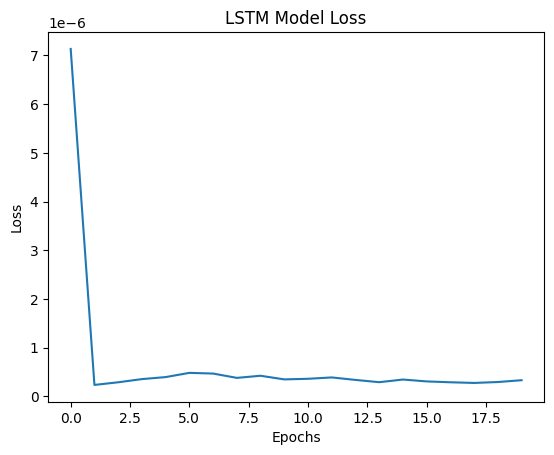

In [ ]:
# Plot the loss over the epochs
plt.plot(history.history['loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Predict the model using test X data
y_pred = model.predict(testX)

16/16 [==============================] - 1s 34ms/step


In [ ]:
# Get a sense of how y_pred looks like
y_pred

array([[-7.92285311e-04, -1.08444001e-05, -4.01165598e-04, ...,
        -4.48119652e-04,  1.03480772e-04, -1.67247563e-04],
       [-7.92067673e-04, -8.36370600e-06, -4.00663062e-04, ...,
        -4.51391126e-04,  1.02157239e-04, -1.68813654e-04],
       [-7.91877857e-04, -7.86963938e-06, -4.00643243e-04, ...,
        -4.51971777e-04,  1.01958445e-04, -1.69144972e-04],
       ...,
       [-7.90267135e-04, -7.46217847e-06, -4.02334583e-04, ...,
        -4.51073749e-04,  9.97766401e-05, -1.70158659e-04],
       [-7.90121732e-04, -3.00071406e-06, -4.00585006e-04, ...,
        -4.56817535e-04,  9.89388573e-05, -1.73182823e-04],
       [-7.90287624e-04, -9.89263935e-06, -4.02360020e-04, ...,
        -4.47516242e-04,  1.02452010e-04, -1.68884755e-04]], dtype=float32)

In [ ]:
print(y_pred.shape)

(487, 10)


###Compute the MSE and RMSE

In [ ]:
mse = mean_squared_error(testY, y_pred)
rmse = math.sqrt(mse)
print("MSE:",mse)
print("RMSE:", rmse)

MSE: 2.787104888094425e-07
RMSE: 0.0005279303825405794


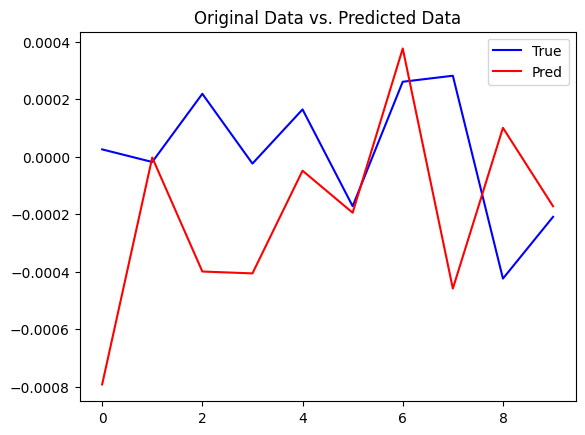

In [ ]:
# Plot one prediction against test data
plt.plot(testY[3], color = "b", label = "True")
plt.plot(y_pred[3], color = "r", label = "Pred")
plt.title('Original Data vs. Predicted Data')
plt.legend()
plt.show()

# Get a single prediction

In [ ]:
# Extract a single observation
single = testX[20].reshape(1, testX[20].shape[0], testX[20].shape[1])
single.shape

(1, 50, 1)

In [ ]:
# Make a prediction
single_pred = model.predict(single)

1/1 [==============================] - 0s 20ms/step


In [ ]:
single_pred

array([[-7.9196092e-04, -1.2126693e-06, -3.9771976e-04, -4.0569078e-04,
        -4.7332196e-05, -1.9422788e-04,  3.7625452e-04, -4.6055744e-04,
         1.0081439e-04, -1.7376051e-04]], dtype=float32)

In [ ]:
single_pred.shape

(1, 10)

In [ ]:
# Get the corresponding test array
single_test = testY[20].reshape(1, testY.shape[1])
single_test.shape

(1, 10)

###Compute the MSE

In [ ]:
mse = mean_squared_error(single_test, single_pred)
print("MSE:", mse)

MSE: 1.4499898605896338e-07


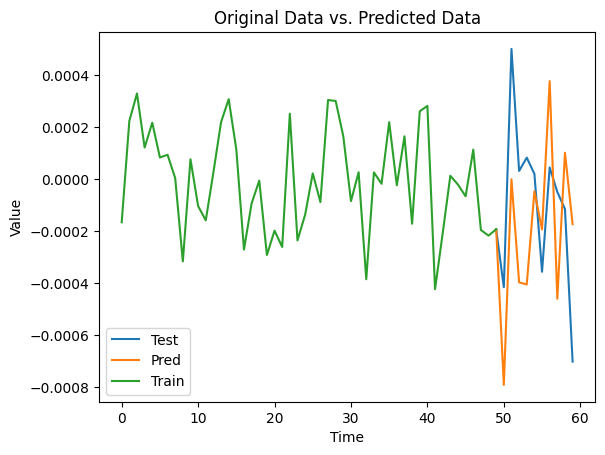

In [ ]:
# Plot
plt.plot(list(range(49,60)), np.insert(single_test.reshape(10,), 0, single[0,49,0]), label='Test')
plt.plot(list(range(49,60)), np.insert(single_pred.reshape(10,), 0, single[0,49,0]), label='Pred')
plt.plot(list(range(0,50)), single.reshape(50,), label='Train')


# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Data vs. Predicted Data')

# Add legend
plt.legend()

# Display the plot
plt.show()

#Plot the predictions

In [ ]:
# Indexing data 
times_exploded = []
forecast_len = testY.shape[1]
idx_list = data.index.to_list()

for i in range(len(data.index) - forecast_len):
  times_exploded.append(pd.to_datetime(idx_list[i : i + forecast_len]))

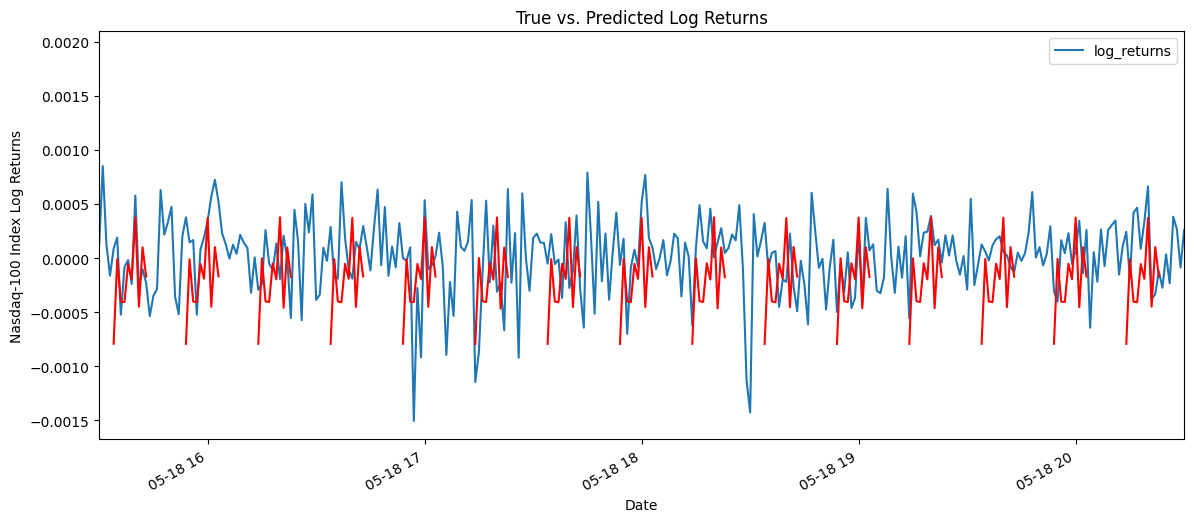

In [ ]:
# Plot the log returns

# Define dates
start_time = pd.to_datetime("2023-05-18 15:30")
end_time = pd.to_datetime("2023-05-18 20:30")

# Adjust x-axis limits
ax = (data.iloc[-len(y_pred):]).plot(
    style="-",
    title="True vs. Predicted Log Returns",
    xlabel="Date",
    ylabel="Nasdaq-100 Index Log Returns",
    xlim=[start_time, end_time],
    figsize=(14, 6))

times = times_exploded[-len(y_pred):]
for idx in range(10, len(y_pred), 20):
  plt.plot(times[idx], y_pred[idx], color = 'r')

# Add legend 
ax.legend()